In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=2)
import normal_pkg.normal as nor
import normal_pkg.adaptation as ada
from normal_pkg.adaptation import CholeskyModule

# Fix the convergence of Proximal algorithm

In [3]:
results_dir = 'normal_pkg/normal_results'
for k in [1]:
    nsteps = 300
    init = 'natural'
    for intervention in ['cause', 'effect']:
        plotname = f'{intervention}_{init}_k={k}'
        filepath = os.path.join(results_dir, plotname + '.pkl')
        if os.path.isfile(filepath):
            with open(filepath, 'rb') as fin:
                results = pickle.load(fin)
print(results[-2])

{'lr': 0.01, 'scheduler_exponent': 0, 'k': 1, 'n': 10, 'T': 300, 'batch_size': 1, 'use_prox': True, 'intervention': 'cause', 'init': 'natural', 'steps': array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290]), 'kl_causal': array([[1.37, 0.53, 0.33, 0.03, 0.36, 0.28, 0.08, 0.08, 0.11, 0.78],
       [1.16, 0.45, 0.3 , 0.04, 0.26, 0.23, 0.06, 0.18, 0.09, 0.47],
       [1.01, 0.38, 0.29, 0.04, 0.21, 0.22, 0.05, 0.08, 0.07, 0.38],
       [0.9 , 0.34, 0.26, 0.04, 0.19, 0.2 , 0.04, 0.05, 0.05, 0.3 ],
       [0.78, 0.29, 0.23, 0.04, 0.17, 0.2 , 0.03, 0.1 , 0.05, 0.21],
       [0.68, 0.25, 0.21, 0.03, 0.13, 0.18, 0.03, 0.03, 0.06, 0.17],
       [0.62, 0.22, 0.19, 0.02, 0.14, 0.16, 0.03, 0.03, 0.04, 0.14],
       [0.55, 0.2 , 0.18, 0.03, 0.12, 0.13, 0.03, 0.04, 0.04, 0.13],
       [0.52, 0.17, 0.16, 0.02, 0.1 , 0.1 , 0.03, 0.02, 0.04, 0.12],
       [0.47, 0.15, 0.14, 0.02, 0.09, 0.

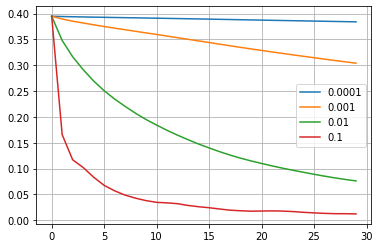

In [4]:
for r in results[:]:
#     print('lr={lr}'.format(r))
    plt.plot(r['kl_causal_average'].mean(1), label=r['lr'])
plt.legend()
plt.grid()

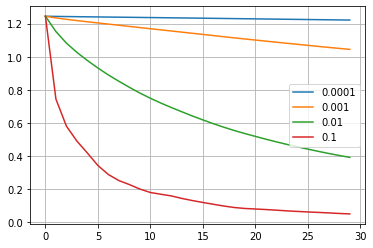

In [5]:
for r in results[:]:
#     print('lr={lr}'.format(r))
    plt.plot(r['scoredist_causal_average'].mean(1), label=r['lr'])
plt.legend()
plt.grid()

In [6]:
print(r['loss'].shape)
print(np.sum(np.isnan(r['loss'])))

(300, 10)
0


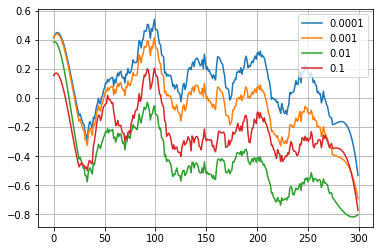

In [7]:
from scipy.signal import savgol_filter

for r in results[:]:
    y = r['loss'].mean(1)
    y = savgol_filter(y, 51, 3)
    plt.plot(y , label=r['lr'])
plt.legend()
plt.grid()


One way to debug is to plot all contributions.

In [8]:
models = r['models'][0] # models for one experiment
direction = 'causal'
endpoint = models[0][direction]
target = models[1][direction]
print('endpoint ',endpoint)
print('target ',target)

endpoint  CholeskyModule(
 	 za=tensor([-0.8257]),
 	 la=tensor([[3.2390]]),
 	 linear=tensor([[-0.6933]]),
 	 bias=tensor([-0.4786]),
 	 lcond=tensor([[0.7585]]))
target  CholeskyModule(
 	 za=tensor([-0.5187]),
 	 la=tensor([[3.1895]]),
 	 linear=tensor([[-0.7276]]),
 	 bias=tensor([-0.4071]),
 	 lcond=tensor([[1.1025]]))


In [9]:
def cholesky_diff(p0, p1):
    z0, L0 = p0.joint_parameters()
    z1, L1 = p1.joint_parameters()
    return z0-z1, L0-L1
import torch
torch.set_printoptions(precision=2, linewidth=200, profile='short')
np.set_printoptions(precision=2, linewidth=200)
u, v = cholesky_diff(target, endpoint)
print(u.detach().numpy())
print(v.detach().numpy())

[0.07 0.31]
[[ 0.34  0.  ]
 [ 0.03 -0.05]]


In [10]:
print('KL')
print(ada.cholesky_kl(target, endpoint, decompose=True))
print(-torch.sum(torch.log(torch.diag(endpoint.joint_parameters()[1]))))
print('\n Distances')
print('total ',target.dist(endpoint))
print('vector ',torch.sum(u**2))
print('diags ',torch.sum(torch.diag(v)**2))
print('not diag ', torch.sum((v - torch.diag(torch.diag(v)))**2))

KL
{'vector': 0.05733523517847061, 'matrix': 0.11273863911628723, 'total': 0.17007386684417725, 'v/t': 0.3371196071587031, 'm/t': 0.6628804366492066}
tensor(-0.90, grad_fn=<NegBackward>)

 Distances
total  tensor(0.22, grad_fn=<AddBackward0>)
vector  tensor(0.10, grad_fn=<SumBackward0>)
diags  tensor(0.12, grad_fn=<SumBackward0>)
not diag  tensor(0.00, grad_fn=<SumBackward0>)


# Fix Priors
show me the average  joint distributions

In [11]:
k = 5
xx = np.random.randn(10000,k,k) / np.sqrt(2*k)
np.mean(xx @ np.swapaxes(xx,1,2), 0)

array([[ 5.03e-01,  3.52e-05,  1.55e-03,  2.69e-03,  1.11e-03],
       [ 3.52e-05,  4.99e-01, -1.78e-03, -6.27e-04,  3.89e-03],
       [ 1.55e-03, -1.78e-03,  4.97e-01,  8.04e-04, -3.81e-03],
       [ 2.69e-03, -6.27e-04,  8.04e-04,  5.02e-01, -9.17e-04],
       [ 1.11e-03,  3.89e-03, -3.81e-03, -9.17e-04,  4.94e-01]])

In [20]:
def print_means(dim,mode, n=500):
    allo = []
    for t in range(n):
        p = nor.sample_natural(dim,mode)
        p = p.to_joint()
        m = p.to_mean()
        hey = [p.eta, m.mean, p.precision, m.cov]
        if t==0:
            print('\n'.join([str(h) for h in hey]))
        hey = [np.abs(u) for u in hey]
        allo += [hey]
        
    everybody = [np.mean([m[i] for m in allo], 0) for i in range(4)]                        
    print('dim=',dim, mode)
    for i, name in enumerate(['eta','mean','precision','covariance']):
        print(name)
        print(everybody[i])

In [23]:
means = print_means(2,'conjugate')

[-0.33  0.34 -0.51  0.37]
[-0.02  0.19 -0.85  0.14]
[[ 3.03 -2.13 -0.09  0.26]
 [-2.13  2.89  0.23 -0.25]
 [-0.09  0.23  0.59 -0.39]
 [ 0.26 -0.25 -0.39  0.61]]
[[ 0.71  0.52 -0.28 -0.27]
 [ 0.52  0.74 -0.28 -0.1 ]
 [-0.28 -0.28  3.09  1.98]
 [-0.27 -0.1   1.98  2.97]]
dim= 2 conjugate
eta
[0.72 0.72 0.21 0.21]
mean
[0.28 0.3  1.1  1.06]
precision
[[3.64 1.07 0.27 0.27]
 [1.07 3.61 0.25 0.26]
 [0.27 0.25 0.3  0.1 ]
 [0.27 0.26 0.1  0.31]]
covariance
[[0.67 0.25 0.62 0.58]
 [0.25 0.67 0.58 0.57]
 [0.62 0.58 8.04 2.81]
 [0.58 0.57 2.81 7.99]]


In [24]:
print_means(2,'naive')

[ 0.84  1.86 -0.77 -0.15]
[ 0.36  0.98  0.45 -0.08]
[[ 6.11 -0.94 -0.93  0.33]
 [-0.94  2.85 -1.35 -0.03]
 [-0.93 -1.35  2.    0.04]
 [ 0.33 -0.03  0.04  3.27]]
[[ 0.23  0.18  0.23 -0.02]
 [ 0.18  0.66  0.53 -0.02]
 [ 0.23  0.53  0.97 -0.03]
 [-0.02 -0.02 -0.03  0.31]]
dim= 2 naive
eta
[1.26 1.19 0.8  0.75]
mean
[0.58 0.64 1.01 0.9 ]
precision
[[4.57 1.37 0.82 0.87]
 [1.37 4.16 0.82 0.82]
 [0.82 0.82 2.98 0.93]
 [0.87 0.82 0.93 2.94]]
covariance
[[0.63 0.25 0.44 0.43]
 [0.25 0.73 0.52 0.5 ]
 [0.44 0.52 2.48 1.43]
 [0.43 0.5  1.43 2.34]]


# Intervention interpolation

In [89]:
from collections import defaultdict
from normal_pkg.distances import intervention_distances

def interpolation_behavior(intervention, d=10, n=1000, alpha=.2):
#     interpolation = np.logspace(-2, 0, n) 
    interpolation = np.linspace(0.001,1,n)
    dist = intervention_distances(d, n, intervention=intervention, interpolation=interpolation)
    dist = {key:np.array(item) for key, item in dist.items()}
    
#     for unit in ['nat','cho']:
#         plt.figure()
# #         plt.xscale('log')
#         for name in ['causal','anti','joint']:
#             key = name+'_'+unit
#             if key in dist:
#                 plt.scatter(interpolation, dist[key], label=name, alpha=alpha)
        
#         plt.ylabel(unit+' distance')
#         plt.grid()
#         plt.legend()
    
    plt.figure()
#     plt.xscale('log')
    for unit in ['nat','cho']:
        plt.scatter(interpolation, dist['anti_'+unit]/dist['causal_'+unit], label=unit, alpha=alpha)
    plt.ylabel('ratio anti/causal')
    plt.grid()
    plt.legend()
    plt.show()

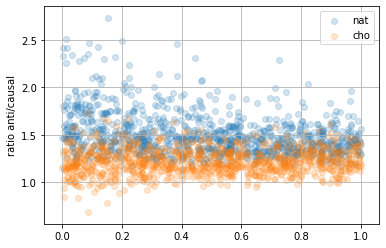

In [85]:
interpolation_behavior('cause')

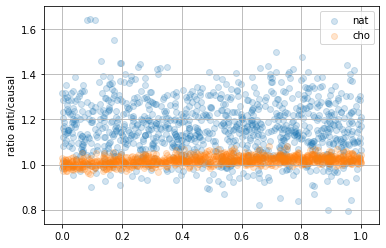

In [86]:
interpolation_behavior('effect')

NOTE: both curves do not start at 0 because I am still making variables independent

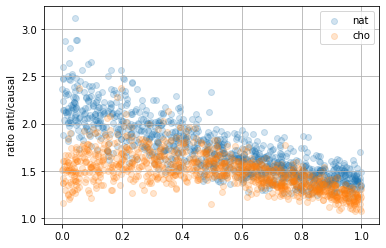

In [87]:
interpolation_behavior('mechanism')

dimension  3 cause


/Library/anaconda/envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


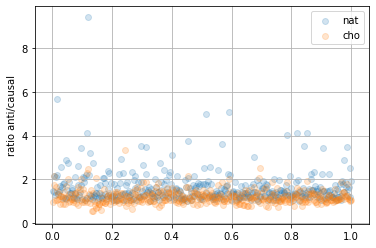

dimension  10 cause


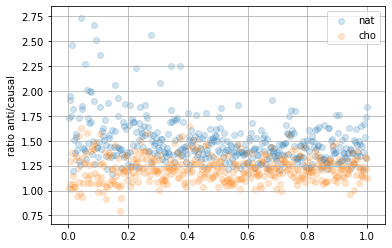

dimension  30 cause


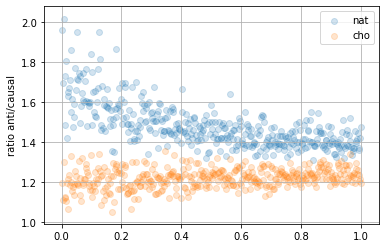

dimension  3 effect


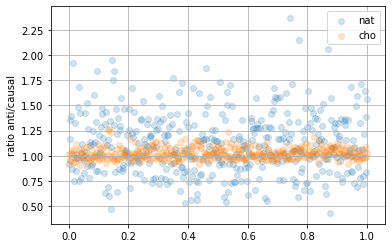

dimension  10 effect


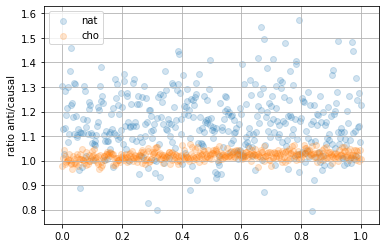

dimension  30 effect


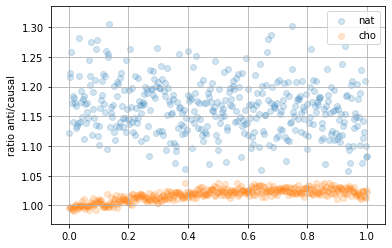

dimension  3 mechanism


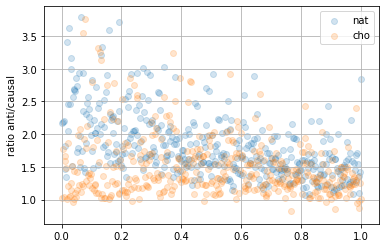

dimension  10 mechanism


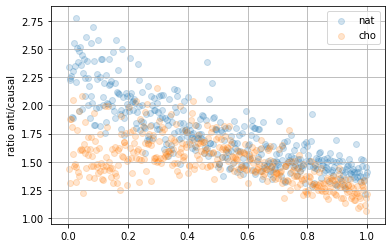

dimension  30 mechanism


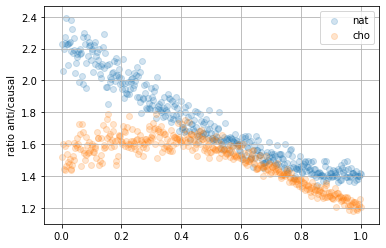

In [90]:
for inter in ['cause','effect','mechanism']:
        for d in [3,10,30]:
            print('dimension ', d, inter)
            interpolation_behavior(inter,d,400)